> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

## Univariate CNN Single -Step
This tutorial is to demonstrate the process in build CNN for the Univariate time series for Multi Step Forecast. It consists of 2 major part which are :

The Demostration of Building CNN using Synthetic data and Exercise of building CNN using shampoo-sales data. First, we will show the step in building the CNN :

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Normalization and Batching the Data)
Step 2. Model Configuration for CNN<br>
Step 3. Train the model<br>
Step 4. Validate the model using graph<br>
Step 5. Evaluation Metrics such as MSE<br>
Step 6. Plot the forecast result<br>

First , let's us import the package needed

In [1]:
# import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import math

In [2]:
def univariate_multi_step(sequence, window_size, n_multistep):
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + window_size
        out_ix = end_ix + n_multistep
        # check if we are beyond the sequence
        if out_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

## Hyper parameter
Define the hyper parameter that need to tune the model

In [3]:
split_ratio = 0.70
num_epochs = 10
window_size = 3
batch_size = 1
n_step = 2
learning_rate = 0.1
# seed
torch.manual_seed(123)

## Data Preparation
We create synthetic data to make sure the model is created correctly and having ability to perform the forecasting

In [4]:
# Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])

split_data = round(len(univariate_series) * split_ratio)
# split data by indexing
train_data = univariate_series[:split_data]
test_data = univariate_series[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


## Data Standardization
The data is scaled to mean = 0 , variance = 1

In [5]:
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standardized = scaler.transform(train_data.reshape(-1, 1))

test_data_standardized  = scaler.transform(test_data.reshape(-1, 1))

## Data Sequencing
Sequencing the data

In [6]:
trainX, trainY = univariate_multi_step(train_data_standardized, window_size, n_step)
testX, testY = univariate_multi_step(test_data_standardized, window_size, n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testX shape:{testY.shape}")

trainX shape:(24, 3, 1) trainY shape:(24, 2, 1)

testX shape:(8, 3, 1) testX shape:(8, 2, 1)


## Data Transform
Data need to transform from numpy to pytorch tensor before feed into the model then perform Data Transpose to make it can feed into CNN model

In [7]:
# transfrom to Pytorch tensor
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:torch.Size([24, 3, 1]) trainY shape:torch.Size([24, 2, 1])

testX shape:torch.Size([8, 3, 1]) testY shape:torch.Size([8, 2, 1])


## Data Transpose 

In [8]:
# Data Transpose to suit for CNN 
trainX = torch.transpose(trainX, 1, 2)
testX = torch.transpose(testX, 1, 2)

print(f"after transpose trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"after transpose shape:{testX.shape} testY shape:{testY.shape}")

after transpose trainX shape:torch.Size([24, 1, 3]) trainY shape:torch.Size([24, 2, 1])

after transpose shape:torch.Size([8, 1, 3]) testY shape:torch.Size([8, 2, 1])


## Data Iterator
Iterator is create to allow the data separate into several batches to fasten the training process

In [9]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## CNN Configuration
The method use to create the model is call pytorch subclass method. It consists of 2 part where the first part is allow user to define the structure of the model such as number of convolution layer , pooling layer and the linear layer

Second part of the method consist of forward() method , it allow user to control the flow of input data.For example , when the data pass in ,it will go throught the conv1 layer first then the output of conv1 layer will become the input for the ReLu activation function.The output of activation output will pass to the next pooling layer.

In [10]:
class CNN_Multistep(nn.Module):

    def __init__(self,timeseries,n_step):
        super(CNN_Multistep, self).__init__()
        self.timeseries=timeseries
        self.n_step = n_step
        
        # Conv1d1d kernel_size is base on the number of time series
        self.conv1 = nn.Conv1d(in_channels=timeseries, out_channels=64, kernel_size=2)
        
        # Maxpool1d kernel_size is base on the number of time series
        # For example Input:(N,C,Lin) Output : (N,C,Lout)
        self.poo1 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64, 50)
        self.fc2 = nn.Linear(50,n_step)

    def forward(self, x):
        
        x = self.poo1(F.relu(self.conv1(x)))
        
        # Flatten
        x = x.view(-1,64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Input Model
The number of time series feed as the attribute for the model. The other attribute such as kernel_size need to configure in the network configuration itself cause some modification is needed when the number of layer increase.

In [11]:
model = CNN_Multistep(timeseries=trainX.shape[1], n_step=n_step)
print(model.eval())
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

CNN_Multistep(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


In [12]:
#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

CNN_Multistep(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

## Training

In [13]:
def training(num_epochs, train_iter, test_iter, optimiser, loss_fn, model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        running_loss_train = 0
        running_loss_valid = 0
        for _, (train_X, train_Y) in enumerate(train_iter):
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to ensure the predicted output (y_train_pred) same size with train_Y shape 
            y_train_pred = torch.reshape(y_train_pred, (train_Y.shape[0], train_Y.shape[1],train_Y.shape[2]))

            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            # Summing up the loss over each epoch
            running_loss_train += loss_train.item()

        # Average the loss base of the batch size
        epoch_loss_train = running_loss_train / len(train_X)
        
        # Store the averaged value
        train_loss[t] = epoch_loss_train

        # Validate the test data loss
        with torch.no_grad():
            for _, (test_X, test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to ensure the predicted output (y_test_pred) same size with test_y shape
                y_test_pred = torch.reshape(y_test_pred, (test_Y.shape[0], test_Y.shape[1],test_Y.shape[2]))
                
                # Calculate the loss
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each epoch
                running_loss_valid += loss_test.item()

        # Average the loss base of the batch size
        epoch_loss_test = running_loss_valid / len(test_X)

        # Store the averaged value
        val_loss[t] = epoch_loss_test

    return train_loss, val_loss

In [14]:
# Start Training
train_loss, val_loss = training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

## Evaluation
A learning curve loss is plotted to define how well the data is fitting the model

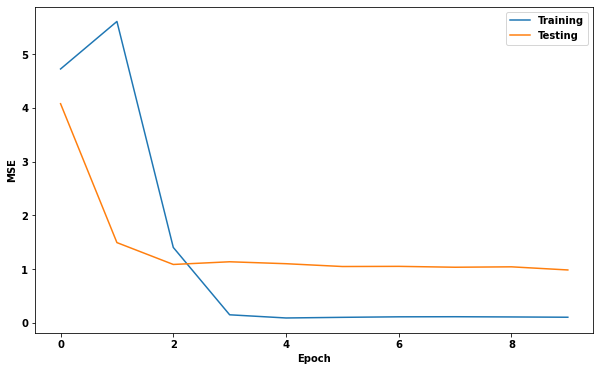

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both train and test prediction back to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data

In [16]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

In [17]:
# Section 2 : Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction, (y_train_prediction.shape[0], y_train_prediction.shape[1]))
trainY = torch.reshape(trainY, (trainY.shape[0], trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction, (y_test_prediction.shape[0], y_test_prediction.shape[1]))
testY = torch.reshape(testY, (testY.shape[0], testY.shape[1]))

In [18]:
# Section 3 : Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [19]:
# Examine the test data and forecast result 
print("Test Data \t\t\t Forecast Result")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

Test Data 			 Forecast Result
[310. 320.]		[293.48804 305.5078 ]
[320. 330.]		[299.93488 312.32825]
[330. 340.]		[306.48297 319.1631 ]
[340. 350.]		[313.05664 325.88873]
[350. 360.]		[319.66437 332.5542 ]
[360. 370.]		[326.27203 339.21967]
[370. 380.]		[332.8797  345.88513]
[380. 390.]		[339.4825  352.54572]


In [20]:
# Section 4 : Calculate the RMSE of train and test data
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 7.43 RMSE
Test Score: 29.65 RMSE


## Exercise for Univariate (Solution)
Use CNN to predict the sales of shampoo<br>
Data Sources : https://www.kaggle.com/djokester/sales-of-shampoo-over-a-three-year-period

In [131]:
#Hyperparameter
num_epochs_shampoo = 500
split_ratio = 0.70
n_step_shampoo = 2
batch_size_shampoo = 1
window_size_shampoo = 3
learing_rate_shampoo = 0.01

#seed
torch.manual_seed(123)

## Data Preparation

In [132]:
shampoo = pd.read_csv('../../datasets/others/shampoo-sales.csv')
shampoo.head()

,month,sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [133]:
shampoo_ts =shampoo['sales']
shampoo_ts.head()

0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
Name: sales, dtype: float64

Text(0.5, 0, 'Month')

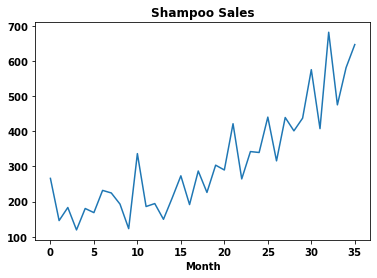

In [134]:
plt.plot(shampoo_ts, label = 'Shampoo Sales')
plt.title("Shampoo Sales")
plt.xlabel("Month")

## Data Splitting

In [135]:
#split data by indexing 
split_data = round(len(shampoo_ts)*split_ratio)
split_data

25

In [136]:
# Split data by indexing 
train_data_shampoo = shampoo_ts[:split_data]
test_data_shampoo = shampoo_ts[split_data:]
train_time = shampoo_ts.index[:split_data]
test_time = shampoo_ts.index[split_data:]
print("train_data_shampoo_shape")
print(train_data_shampoo.shape)
print("test_data_shampoo_shape")
print(test_data_shampoo.shape)

train_data_shampoo_shape
(25,)
test_data_shampoo_shape
(11,)


Text(0, 0.5, 'Sales')

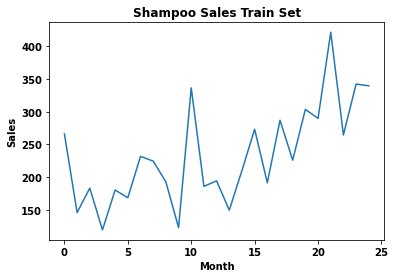

In [137]:
# Train Data Set
plt.plot(train_time,train_data_shampoo)
plt.title("Shampoo Sales Train Set")
plt.xlabel("Month")
plt.ylabel("Sales")

Text(0, 0.5, 'Sales')

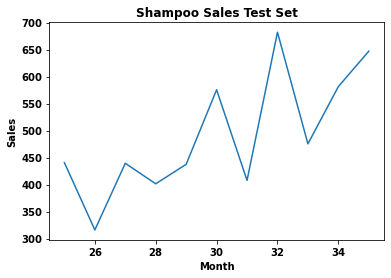

In [138]:
# Test Data Set
plt.plot(test_time,test_data_shampoo)
plt.title("Shampoo Sales Test Set")
plt.xlabel("Month")
plt.ylabel("Sales")

## Data Standardization
Data scale to mean = 0 and variace = 1

In [139]:
#Reshape before normalize
train_data_shampoo = train_data_shampoo.values.reshape(-1, 1)
test_data_shampoo = test_data_shampoo.values.reshape((-1, 1))

#Build Scaler
scaler_shampoo = StandardScaler().fit(train_data_shampoo)
train_data_normalized_shampoo = scaler_shampoo.transform(train_data_shampoo)

test_data_normalized_shampoo = scaler_shampoo.transform(test_data_shampoo)
train_data_normalized_shampoo[1:6]

array([[-1.17274392],
       [-0.67771312],
       [-1.52671755],
       [-0.71497351],
       [-0.8719994 ]])

## Data Seqeuncing

In [140]:
#Data Sequencing 
trainX_shampoo ,trainY_shampoo =  univariate_multi_step(train_data_normalized_shampoo,window_size_shampoo,n_step_shampoo)
testX_shampoo , testY_shampoo = univariate_multi_step(test_data_normalized_shampoo,window_size_shampoo,n_step_shampoo)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testY shape:{testY_shampoo.shape}")

trainX shape:(21, 3, 1) trainY shape:(21, 2, 1)

testX shape:(7, 3, 1) testY shape:(7, 2, 1)


## Data Transform
Transfrom numpy to Pytorch tensor 

In [141]:
#Transfrom numpy to Pytorch tensor
trainX_shampoo = torch.from_numpy(trainX_shampoo).type(torch.Tensor)
trainY_shampoo = torch.from_numpy(trainY_shampoo).type(torch.Tensor)
testX_shampoo = torch.from_numpy(testX_shampoo).type(torch.Tensor)
testY_shampoo = torch.from_numpy(testY_shampoo).type(torch.Tensor)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")

trainX shape:torch.Size([21, 3, 1]) trainY shape:torch.Size([21, 2, 1])

testX shape:torch.Size([7, 3, 1]) testX shape:torch.Size([7, 2, 1])


## Data Transpose

In [142]:
# Data Transpose to suit for CNN 
trainX_shampoo = torch.transpose(trainX_shampoo, 1, 2)
testX_shampoo= torch.transpose(testX_shampoo, 1, 2)

print(f"after transpose trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"after transpose shape:{testX.shape} testY shape:{testY.shape}")

after transpose trainX shape:torch.Size([24, 1, 3]) trainY shape:torch.Size([24, 2])

after transpose shape:torch.Size([8, 1, 3]) testY shape:torch.Size([8, 2])


## Data Iterator

In [143]:
# Create Iterator
train_dataset_shampoo = TensorDataset(trainX_shampoo, trainY_shampoo)
train_iter_shampoo = DataLoader(train_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

test_dataset_shampoo = TensorDataset(testX_shampoo, testY_shampoo)
test_iter_shampoo = DataLoader(test_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

## Input Model
The number of time series feed as the attribute for the model. The other attribute such as kernel_size need to configure in the network configuration itself cause some modification is needed when the number of layer increase.

In [144]:
model_shampoo = CNN_Multistep(timeseries=trainX_shampoo.shape[1], n_step=n_step_shampoo)
print(model_shampoo.eval())
optimiser_shampoo = torch.optim.SGD(model_shampoo.parameters(), lr=learing_rate_shampoo)
loss_fn_shampoo = nn.MSELoss()

CNN_Multistep(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


In [145]:
# Xavier weight intialization
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model_shampoo.apply(weights_init)

CNN_Multistep(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

In [146]:
# Start Training 
train_loss_shampoo,val_loss_shampoo = training(num_epochs_shampoo,train_iter_shampoo,test_iter_shampoo,optimiser_shampoo,loss_fn_shampoo,model_shampoo)

## Evaluate
Plot the learning curve to evaluate the loss of each epoch 

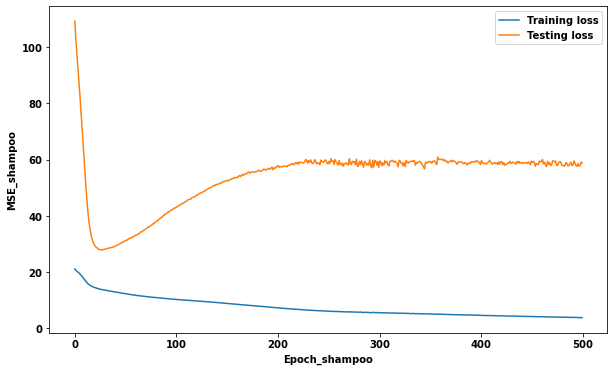

In [147]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_shampoo, label="Training loss")
plt.plot(val_loss_shampoo, label="Testing loss")
plt.xlabel("Epoch_shampoo")
plt.ylabel("MSE_shampoo")
plt.legend()
plt.show()

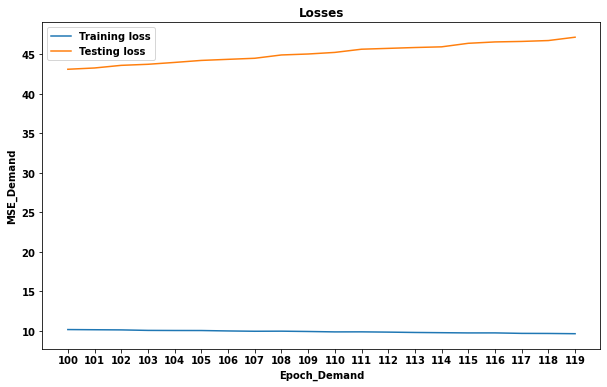

In [148]:
# Zoom in by fill in start_epoch and end_epoch
start_epoch = 100
end_epoch = 120
plt.figure(figsize=(10,6))
plt.plot(train_loss_shampoo[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_shampoo[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both train and test prediction back to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data

In [149]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction_shampoo= model_shampoo(trainX_shampoo)
    y_test_prediction_shampoo= model_shampoo(testX_shampoo)

# Section 2 : Reshape to original data
y_train_prediction_shampoo = torch.reshape(y_train_prediction_shampoo,(y_train_prediction_shampoo.shape[0],y_train_prediction_shampoo.shape[1]))
trainY_shampoo = torch.reshape(trainY_shampoo,(trainY_shampoo.shape[0],trainY_shampoo.shape[1]))
y_test_prediction_shampoo = torch.reshape(y_test_prediction_shampoo,(y_test_prediction_shampoo.shape[0],y_test_prediction_shampoo.shape[1]))
testY_shampoo = torch.reshape(testY_shampoo,(testY_shampoo.shape[0],testY_shampoo.shape[1]))

In [150]:
# Section 3 : Invert predictions
y_train_pred_shampoo = scaler_shampoo.inverse_transform(y_train_prediction_shampoo.detach().numpy())
y_train_shampoo = scaler_shampoo.inverse_transform(trainY_shampoo.detach().numpy())
y_test_pred_shampoo = scaler_shampoo.inverse_transform(y_test_prediction_shampoo.detach().numpy())
y_test_shampoo = scaler_shampoo.inverse_transform(testY_shampoo.detach().numpy())

In [151]:
# Examine the test data and forecast result 
print("Test Data \t\t\t Forecast Result")
for i in range(len(y_test_shampoo)):
    print(f"{y_test_shampoo[i]}\t\t{y_test_pred_shampoo[i]}")

Test Data 			 Forecast Result
[401.30002 437.4    ]		[360.05826 334.83038]
[437.4 575.5]		[411.21988 302.664  ]
[575.5 407.6]		[358.58896 356.0555 ]
[407.6 682. ]		[191.69705 397.58963]
[682.  475.3]		[318.74176 385.26434]
[475.3 581.3]		[270.57245 366.42288]
[581.3 646.9]		[326.05093 320.46872]


In [152]:
#calculate root mean squared error for the train and test data
trainScore_shampoo = math.sqrt(mean_squared_error(y_train_shampoo[:,0], y_train_pred_shampoo[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_shampoo))
testScore_shampoo = math.sqrt(mean_squared_error(y_test_shampoo[:,0], y_test_pred_shampoo[:,0]))
print('Test Score: %.2f RMSE' % (testScore_shampoo))

Train Score: 24.59 RMSE
Test Score: 218.79 RMSE


## Plot the Forecast Result 
- Blue Line-Indicate as test data before sequencing
- Green Line-Indicate as the testY data after sequencing
- Red Line-Indicate as the predicted testY data (Forecast) after sequencing 

Window size = 4 , hence the time need start from +3 due to taking 3 data point as x-feature.

- **x-feature = window size -1**

[ time+3,time+4 ] - This is because n_step_demand = 2 <br>
If n_step_demand = 3 ,[ time+3,time+4,time_5 ] is need

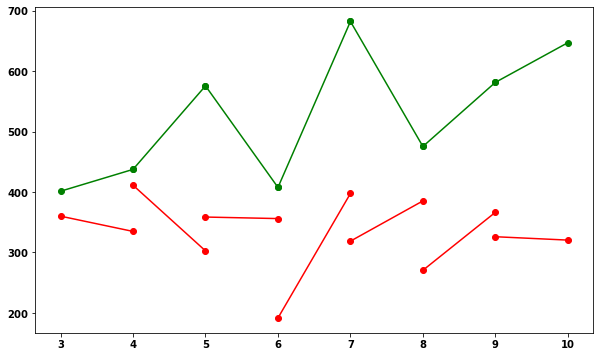

In [153]:
# Plot testY and predictionY data
plt.figure(figsize=(10,6))

for time in range(len(y_test_shampoo)):
        testY_data=[y_test_shampoo[time][0],y_test_shampoo[time][1]]
        plt.plot([time+window_size_shampoo,time+window_size_shampoo+1],testY_data,color="green",marker='o',label='TestY')
    
        text_prediction_data=[y_test_pred_shampoo[time][0],y_test_pred_shampoo[time][1]]
        plt.plot([time+window_size_shampoo,time+window_size_shampoo+1], text_prediction_data,color="red",marker='o',label='Forecast')

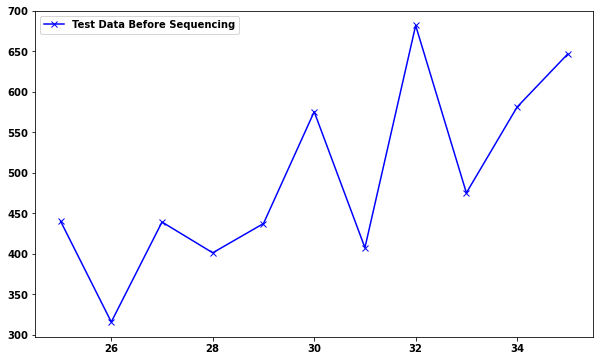

In [154]:
# Plot Original Test Data
plt.figure(figsize=(10,6))
plt.plot(test_time,test_data_shampoo,marker='x',color="blue",label="Test Data Before Sequencing")
plt.legend()

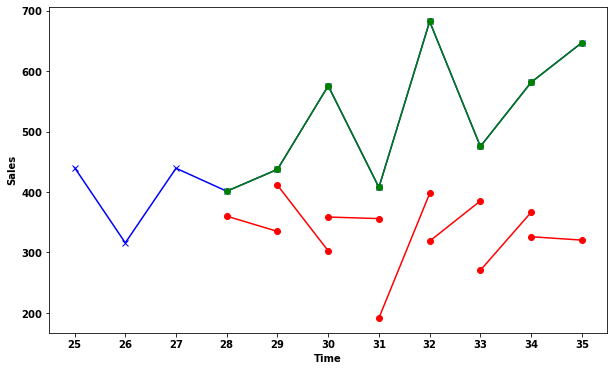

In [155]:
# Combine the orginal test data , testY and predict testY after sequencing and plot it
plt.figure(figsize=(10,6))
position = range(len(test_data_shampoo))
label=test_time
plt.xticks(position, label)
plt.plot(test_data_shampoo[:,-1],marker='x',color="blue",label="Test Data Before Sequencing")
plt.xlabel("Time")
plt.ylabel("Sales")

for time in range(len(y_test_shampoo)):
        testY_data=[y_test_shampoo[time][0],y_test_shampoo[time][1]]
        plt.plot([time+window_size_shampoo,time+window_size_shampoo+1],testY_data,color="green",marker='o',label='TestY')
    
        text_prediction_data=[y_test_pred_shampoo[time][0],y_test_pred_shampoo[time][1]]
        plt.plot([time+window_size_shampoo,time+window_size_shampoo+1], text_prediction_data,color="red",marker='o',label='Forecast')

## Reference
1. https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
2. Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee